In [1]:
import numpy as np
from numpy.linalg import inv, pinv, norm, qr
from matplotlib import pyplot as plt

In [2]:
def compute_SMW(n,k,A,B,U,V,lamda,e1,e2,rand_seed=1):
    # np.random.seed(rand_seed)    \
    # add noise
    noise1 = np.random.normal(size=(n,n))
    noise1 *= e1/norm(noise1,ord=2)
    noise2 = np.random.normal(size=(k,k))
    noise2 *= e2/norm(noise2,ord=2)

    A_inv = inv(A)
    A_til_inv = A_inv + noise1
    Z_inv = inv(np.eye(k)+V.T@A_til_inv@U) + noise2
    B_inv_approx = A_til_inv - A_til_inv@U@Z_inv@V.T@A_til_inv
    error = norm(B-inv(B_inv_approx),ord=2)
    beta = np.linalg.norm(np.eye(k)+V.T@A_inv@U,ord=2)
    bound = 4*lamda*e2*beta**2
    full_bound = 2*e1*norm(A,ord=2)**2 + 4*lamda*e2*(beta+lamda*e1)**2
    return error,bound,full_bound#,2*e1*norm(A,ord=2)**2


# Large Update 

In [23]:
n = 1000; k = 20
epsilon = 1e-6
num_experiments = 100
S_A = np.logspace(2,-2,n)
A = np.diag(S_A)
sigma_max, sigma_min = np.max(S_A), np.min(S_A)
lamda = 2*sigma_max #2*sigma_max
assert epsilon < 1/2/sigma_max
index_list = list(range(int(n/4),int(n*3/4),20))
betas = np.zeros(len(index_list),dtype=float)
errors = np.zeros(len(betas),dtype=float)
bounds = np.zeros(len(betas),dtype=float)
full_bounds = np.zeros(len(betas),dtype=float)

for i, index in enumerate(index_list):
    I = np.eye(n)
    Q = I[:, index:index + 20]
    U = A @ Q
    U_norm = norm(U, ord=2)
    V_norm = lamda / U_norm
    beta_total = 0.0
    error_total = 0.0
    bound_total = 0.0
    full_bound_total = 0.0
    for experiment in range(num_experiments):
        # Generate a new S for each experiment
        S = np.random.randn(k, k)
        S *= V_norm / norm(S, ord=2)
        V = Q @ S.T
        # Compute beta for this experiment
        beta = norm(np.eye(k) + V.T @ inv(A) @ U, ord=2)
        beta_total += beta
        assert epsilon < 1/2/(beta+lamda*epsilon)
        # assert 2*(beta+lamda*epsilon)**2 * epsilon < 0.5
        B = A + U @ V.T
        err, b, fb = compute_SMW(n, k, A, B, U, V, lamda, epsilon, epsilon)
        error_total += err
        bound_total += b
        full_bound_total += fb

    # Store the average values over the experiments
    betas[i] = beta_total / num_experiments
    errors[i] = error_total / num_experiments
    bounds[i] = bound_total / num_experiments
    full_bounds[i] = full_bound_total / num_experiments



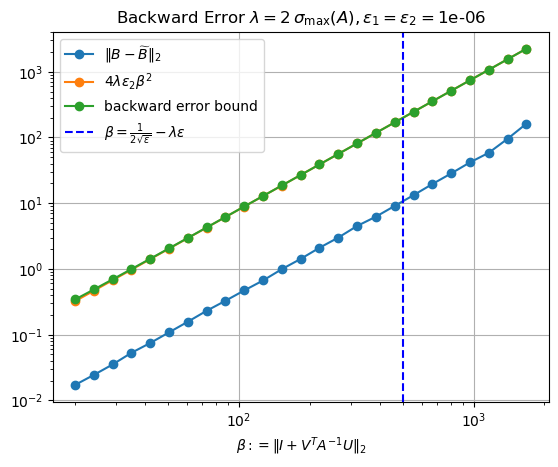

In [24]:
plt.loglog(betas,errors,label=r'$\|B-\widetilde{B}\|_2$',marker='o')
plt.loglog(betas,bounds,label=r'$ 4\lambda\epsilon_2 \beta^2$',marker='o')
plt.loglog(betas,full_bounds,label='backward error bound',marker='o')
# plt.loglog(betas,first_terms,label=r'$2\|A\|_2^2\epsilon_1$')
x_val1 = 1/2/epsilon - lamda*epsilon
x_val2 = 1/2/np.sqrt(epsilon) - lamda*epsilon
# plt.axvline(x=x_val1, color = 'red', linestyle='--', label=r'$\frac{1}{2\epsilon}-\lambda \epsilon$')
plt.axvline(x=x_val2, color = 'blue',  linestyle='--', label=r'$\beta =\frac{1}{2\sqrt{\epsilon}}-\lambda \epsilon$')

plt.xlabel(r'$\beta := \|I + V^T A^{-1} U\|_{2}$')
plt.title("Backward Error "+r'$\lambda = 2\,\sigma_{\max}(A), \epsilon_1 = \epsilon_2 = $'+str(epsilon))
plt.legend()
plt.grid()
plt.savefig("diagonal_experiments/diagonal_backward_error_large_update.png")




# Small Update

In [20]:
n = 1000; k = 20
epsilon = 1e-6
num_experiments = 100
S_A = list(np.logspace(-2,-8,int(n*0.6)))+[1e-8 for i in range(n-int(n*0.6))]
A = np.diag(S_A)
sigma_max, sigma_min = np.max(S_A), np.min(S_A)
lamda = 100*sigma_min
assert epsilon < 1/2/sigma_max
index_list = list(range(int(n/4),int(n*3/4),20))
betas = np.zeros(len(index_list),dtype=float)
errors = np.zeros(len(betas),dtype=float)
bounds = np.zeros(len(betas),dtype=float)
full_bounds = np.zeros(len(betas),dtype=float)

for i, index in enumerate(index_list):
    I = np.eye(n)
    Q = I[:, index:index + 20]
    U = A @ Q
    U_norm = norm(U, ord=2)
    V_norm = lamda / U_norm
    beta_total = 0.0
    error_total = 0.0
    bound_total = 0.0
    full_bound_total = 0.0
    for experiment in range(num_experiments):
        # Generate a new S for each experiment
        S = np.random.randn(k, k)
        S *= V_norm / norm(S, ord=2)
        V = Q @ S.T
        # Compute beta for this experiment
        beta = norm(np.eye(k) + V.T @ inv(A) @ U, ord=2)
        beta_total += beta
        assert epsilon < 1/2/(beta+lamda*epsilon)
        assert 2*(beta+lamda*epsilon)**2 * epsilon < 0.5
        B = A + U @ V.T
        err, b, fb = compute_SMW(n, k, A, B, U, V, lamda, epsilon, epsilon)
        error_total += err
        bound_total += b
        full_bound_total += fb

    # Store the average values over the experiments
    betas[i] = beta_total / num_experiments
    errors[i] = error_total / num_experiments
    bounds[i] = bound_total / num_experiments
    full_bounds[i] = full_bound_total / num_experiments



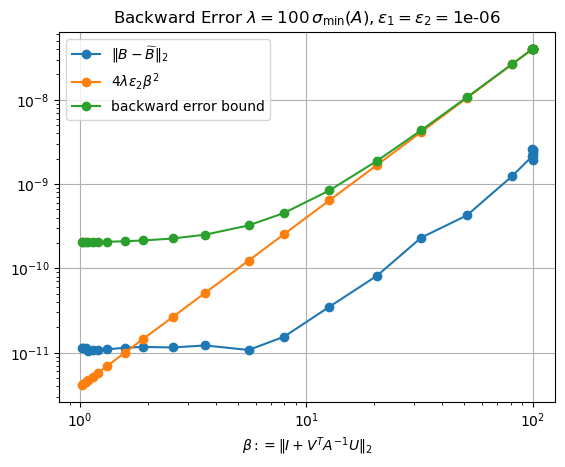

In [22]:
plt.loglog(betas,errors,label=r'$\|B-\widetilde{B}\|_2$',marker='o')
plt.loglog(betas,bounds,label=r'$ 4\lambda\epsilon_2 \beta^2$',marker='o')
plt.loglog(betas,full_bounds,label='backward error bound',marker='o')
# plt.loglog(betas,first_terms,label=r'$2\|A\|_2^2\epsilon_1$')
x_val1 = 1/2/epsilon - lamda*epsilon
x_val2 = 1/2/np.sqrt(epsilon) - lamda*epsilon
# plt.axvline(x=x_val1, color = 'red', linestyle='--', label=r'$\frac{1}{2\epsilon}-\lambda \epsilon$')
# plt.axvline(x=x_val2, color = 'blue',  linestyle='--', label=r'$\beta =\frac{1}{2\sqrt{\epsilon}}-\lambda \epsilon$')

plt.xlabel(r'$\beta := \|I + V^T A^{-1} U\|_{2}$')
plt.title("Backward Error "+r'$\lambda = 100\,\sigma_{\min}(A), \epsilon_1 = \epsilon_2 = $'+str(epsilon))
plt.legend()
plt.grid()
plt.savefig("diagonal_experiments/diagonal_backward_error_small_update.png")